# Práctica 2 - Ejercicio 4: Predicción de Energía con Series Temporales Multivariantes y datos climáticos

**Asignatura**: Machine Learning, 2025/2026

**Profesora**: Jose Tomas, Palma Mendez

**Máster de Inteligencia Artificial**
**Autores:**  
- Jesús Guirado Pérez  
- Antonio Luis Sánchez Torres  
- Víctor Emilio Vicente García

## Índice
1. [Introducción](#intro)
2. [Lectura y Preparación de Datos](#lectura)
3. [Modelo Línea Base](#linea-base)
4. [Estrategia de Evaluación](#eval)
5. [Modelos Avanzados con Grid Search](#modelos)
   1. [Random Forest](#random)
   2. [XGBoost](#xgboost)
   3. [SVR](#svr)
6. [Comparación y Conclusiones](#conclu)

 [Uso de IA Generativa](#genia)

 [Entorno de Ejecución](#entorno)

## Introducción <a class="anchor" id="intro"></a>

En este notebook vamos a realizar el ejercicio 2.4 de predicción de energía con series temporales multivariables añadiendo además los datos climáticos. En terminos generales vamos a continuar con los mismos algoritmos y estrategias que en el ejercicio anterior pero con estrategias multivariables.

## Lectura y Preparación de Datos <a class="anchor" id="lectura"></a>

En esta sección se cargan los datos previamente preprocesados y analizados en el notebook `practica2_ejercicio1.ipynb`

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelos de Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Skforecast para series temporales multivariantes
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries, grid_search_forecaster_multiseries

## Graficos
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# CONSTANTES
TARGET = 'Energía total (kWh)'
HORIZONTE = 7  # días
LAGS = 7
SEED = 42

### Configuración de lags

La serie temporal de energía ha demostrado ser **estacionaria** tras el análisis ADF (Augmented Dickey-Fuller) realizado en el ejercicio 1. Tanto a nivel semanal como a nivel anual. Por lo que la estrategía de elección de lags lo vamos a baser en esto.

**Estrategia de lags:**

Se utilizarán dos configuraciones de lags basadas en los patrones identificados:

1. **Lags semanales y anuales**: `[7, 30, 183, 365]`
   - Lag 7: Captura el patrón semanal (7 días anteriores)
   - Lag 30: Captura el patrón mensual (1 mes anterior)
   - Lag 183: Captura el patrón semestral (6 meses anteriores)
   - Lag 365: Captura el patrón anual (año anterior)

2. **Lags diarios recientes + anuales**: `[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]`
   - Lags 1-7: Semana completa anterior (captura tendencias recientes)
   - Lags 359-365: Días cercanos al mismo período del año anterior (captura estacionalidad anual)
   - Mantenemos un número reducido de lags (14) mientras capturamos tendencia reciente y estacionalidad anual.


In [ ]:
# Configuraciones de lags basadas en estacionalidad semanal y mensual/anual
# Config 1: Lags estratégicos (semanal, mensual, semestral, anual)
lags_grid_estrategicos = [7, 30, 183, 365]

# Config 2: Lags diarios recientes + contexto anual
lags_grid_diarios_anuales = [[1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 364, 365]]

# Grid completo para búsqueda
lags_grid = lags_grid_estrategicos + lags_grid_diarios_anuales

Vamos a eliminar 'Emisión (kg CO₂)' porque tiene una correlación lineal perfecta 
con 'Energía total (kWh)', nuestra variable objetivo. Al ser variables proporcionales 
entre sí (en el mismo instante temporal), la información de una está completamente 
contenida en la otra, generando redundancia. Mantener ambas no aporta valor predictivo 
adicional y puede causar problemas de multicolinealidad en algunos modelos.
Además intuimos que es una columna que se calcula atraves de 'Energía total (kWh)'. Con esto tambien agilizamos los tiempos de entrenamiento reduciendo el tamaño de nuestro dataset sin perder información.

In [3]:
# Cargar datos
energia_preprocesada = pd.read_csv('Data/energia_preprocesada.csv', index_col=0, parse_dates=True)
# Establecer frecuencia diaria
energia_preprocesada = energia_preprocesada.asfreq('D')
energia_preprocesada = energia_preprocesada.drop(columns="Día de la semana")


if 'Emisión (kg CO₂)' in energia_preprocesada.columns:
    energia_preprocesada = energia_preprocesada.drop('Emisión (kg CO₂)', axis=1)
    display(energia_preprocesada.head())

,Electricidad (kW),Fotovoltaica (kW),Refrigeración (kW),Calefacción (kWh),Energía total (kWh),es_fin_semana
2014-01-01,490049.28,62795.47,243369.71770,20107.60131,753526.59901,False
2014-01-02,556486.56,64284.00,323886.05169,23987.86135,904360.47304,False
2014-01-03,545831.45,67187.06,337004.60237,22112.20695,904948.25932,False
2014-01-04,511495.56,46798.28,252493.06189,21074.73561,785063.35750,True
2014-01-05,502806.80,70162.87,249265.37031,22777.47812,774849.64843,True


Vamos a dividir el dataset en train y test, para ello hemos elegido la estrategia de hold out con 80, 20 ya que es estandar en la industria. Además es la misma estrategía que utilizamos en el ejercicio 2.

In [4]:
# División train/test 80/20
train_index = int(len(energia_preprocesada) * 0.8)
train_data = energia_preprocesada.iloc[:train_index]
train_data = train_data.asfreq('D')
test_data = energia_preprocesada.iloc[train_index:]
test_data = test_data.asfreq('D')


Se incorpora el 'día de la semana' como variable exógena, ya que es una variable 
determinista conocida tanto en el pasado como en el futuro, independiente de la 
variable objetivo. Esta variable puede capturar patrones de estacionalidad semanal 
en el consumo energético (e.g., diferencias entre días laborables y fines de semana) como vimos durante el análisis. 

In [5]:
# Crear variable exógena: día de la semana
exog_train = pd.DataFrame({
    'dia_semana': train_data.index.dayofweek
}, index=train_data.index)

exog_test = pd.DataFrame({
    'dia_semana': test_data.index.dayofweek
}, index=test_data.index)

# Para backtesting, necesitamos exog para todo el conjunto de datos
exog_completo = pd.DataFrame({
    'dia_semana': energia_preprocesada.index.dayofweek
}, index=energia_preprocesada.index)

Ahora se muestra el resultado de las operaciones realizadas y los conjuntos de train y test gráficamente.

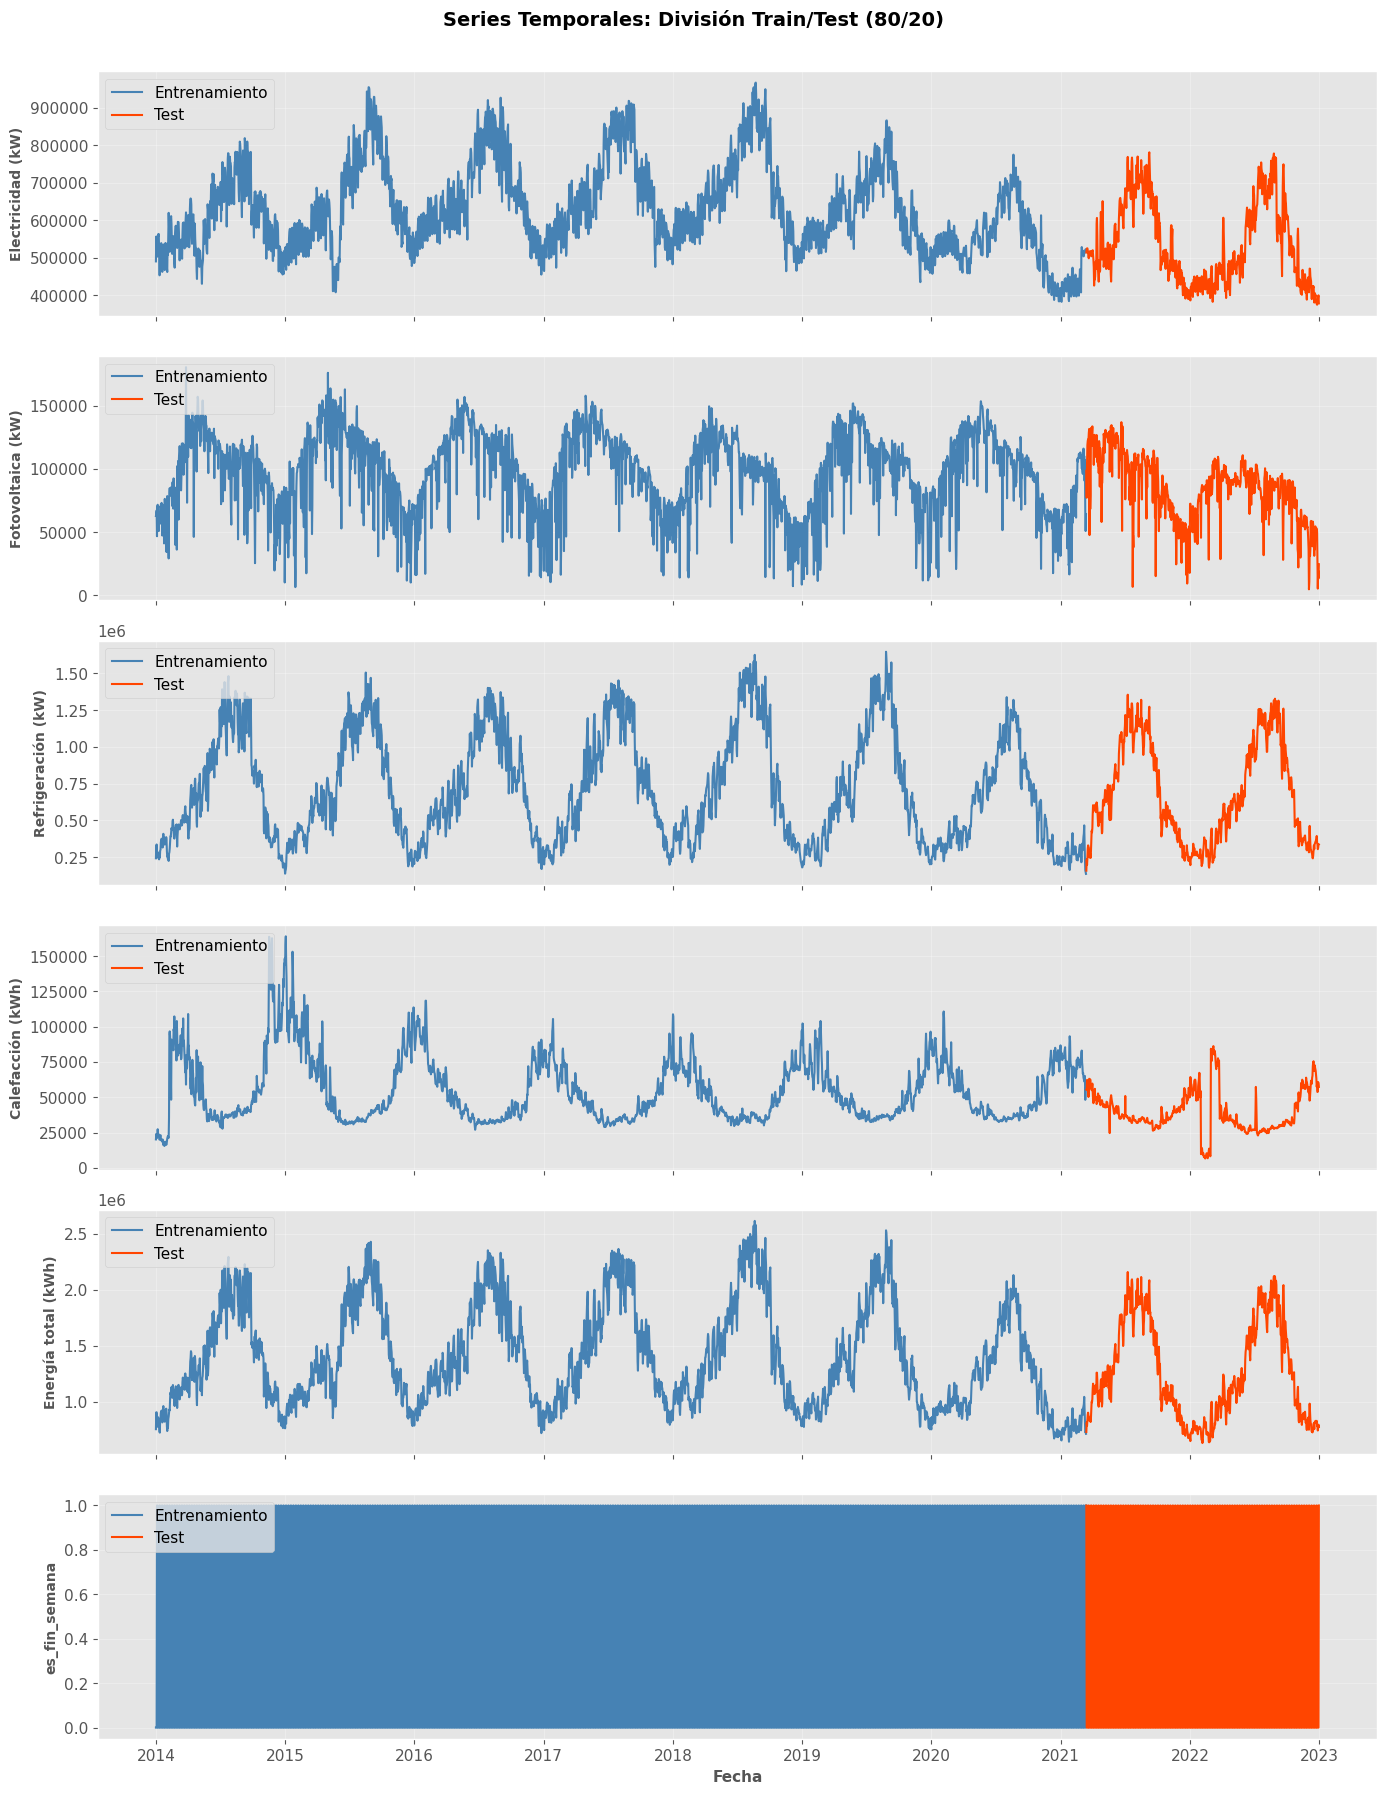

In [6]:
# Visualización de la división train/test
n_series = len(energia_preprocesada.columns)
fig, axes = plt.subplots(n_series, 1, figsize=(14, 3*n_series), sharex=True)

if n_series == 1:
    axes = [axes]

for i, col in enumerate(energia_preprocesada.columns):
    ax = axes[i]
    ax.plot(train_data.index, train_data[col], color='steelblue', label='Entrenamiento', linewidth=1.5)
    ax.plot(test_data.index, test_data[col], color='orangered', label='Test', linewidth=1.5)
    ax.set_ylabel(col, fontsize=10, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Fecha', fontsize=11, fontweight='bold')
fig.suptitle('Series Temporales: División Train/Test (80/20)', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

## 2. Modelo Línea Base <a class="anchor" id="linea-base"></a>

Vamos a utilizar un **modelo baseline simple** basado en la media entre el día anterior al horizonte y el mismo día del año anterior.

Esta estrategia captura tanto la tendencia reciente como la estacionalidad anual de forma simple y computacionalmente eficiente.

**Estrategia para horizonte de 7 días:**
- **h=1**: Predicción = media(último_día_train, mismo_día_año_anterior)
- **h=2**: Predicción = media(predicción_h1, día_año_anterior_correspondiente)
- **h=3 a h=7**: Se continúa usando la predicción anterior y el día del año anterior correspondiente

Este modelo es simple pero efectivo para series con fuerte estacionalidad anual, y servirá como referencia para compararlo con modelos más complejos.

Tambien hemos estudiado la alternativa de usar solo el día anterior, por eso nuestra función nos permite elegir si utilizar la media de dos días o solo el día anterior con el parámetro 'media2dias'. Tras evaluar con el conjunto de train y test el mejor resultado ha sido utilizando la media entre el último día conocido y el mismo día del año anterior. Por lo que finalmente hemos utilizado ese modelo.

In [7]:
# Función para crear predicciones baseline con media de día anterior + mismo día año anterior
def crear_baseline_predicciones(train_data, target_column, media2Dias=False,horizonte=7):
    predicciones = []
    fechas_pred = []
    
    # Obtener el último valor de train y su índice
    ultimo_idx_train = train_data.index[-1]
    ultimo_valor = train_data[target_column].iloc[-1]
    
    for h in range(1, horizonte + 1):
        # Fecha de la predicción
        fecha_pred = ultimo_idx_train + pd.Timedelta(days=h)
        fechas_pred.append(fecha_pred)
        
        # Fecha del mismo día del año anterior
        fecha_año_anterior = fecha_pred - pd.Timedelta(days=365)
        
        idx_cercano = train_data.index.get_indexer([fecha_año_anterior], method='nearest')[0]
        valor_año_anterior = train_data[target_column].iloc[idx_cercano]
        
        # Para h=1, usar el último día de train
        # Para h>1, usar la predicción anterior
        if h == 1:
            valor_anterior = ultimo_valor
        else:
            valor_anterior = predicciones[-1]
        
        # Predicción como media simple
        
        if(media2Dias):
            pred = (valor_anterior + valor_año_anterior) / 2
            predicciones.append(pred)
        else:
            predicciones.append(valor_anterior)
    
    # Crear serie con las predicciones
    predicciones_serie = pd.Series(predicciones, index=fechas_pred, name='pred')
    
    return predicciones_serie

# Crear predicciones baseline
prediccion_inicial = crear_baseline_predicciones(train_data, target_column=TARGET, media2Dias=True, horizonte=HORIZONTE)

# Convertir a DataFrame para mantener consistencia con código posterior
prediccion_inicial = pd.DataFrame(prediccion_inicial)

Vamos a visualizar los primeros 7 días predichos con el modelo baseline simple comparándolos con los valores reales.

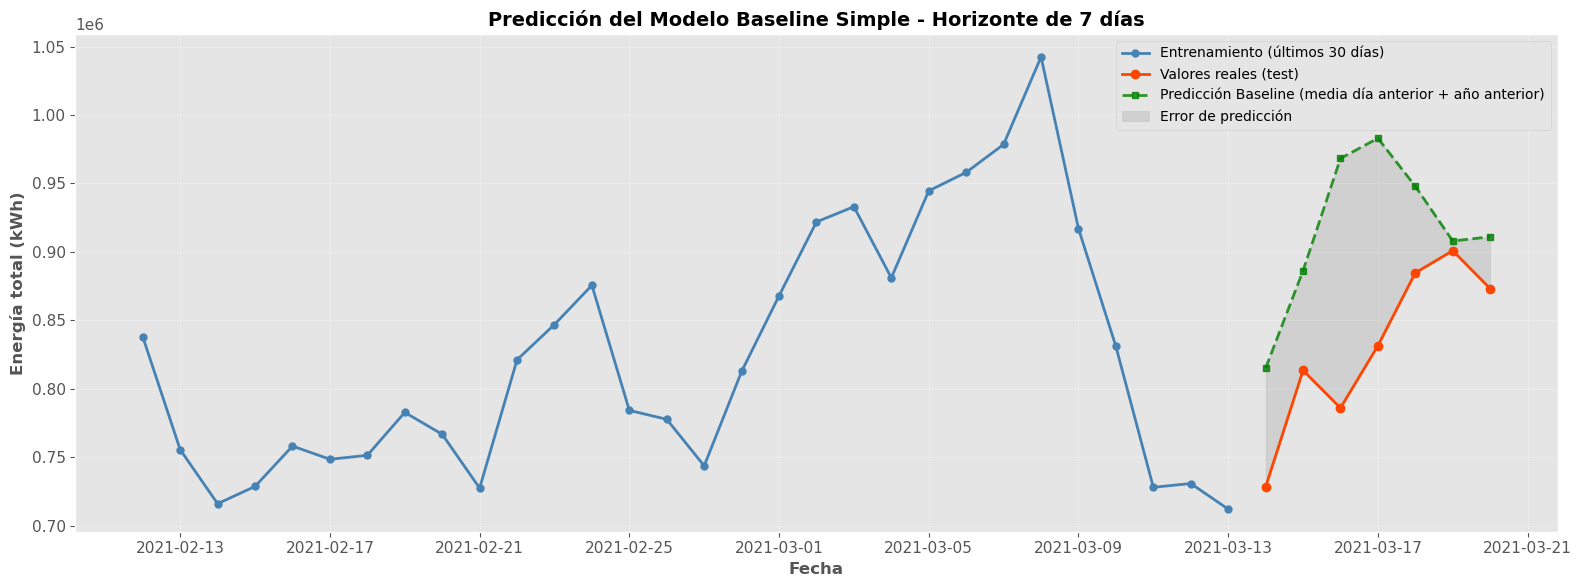

In [8]:
# Visualizar la predicción del modelo baseline
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train_data[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test_data[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial['pred'], 
        's--', color='green', label='Predicción Baseline (media día anterior + año anterior)', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial['pred'],
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline Simple - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Se puede ver que los resultados son buenos para los primeros 2 días y despues se produce una desviación más intensa en el tercer, cuarto y quinto día mientras que en el sexto y septimo vuelve a dar resultados parecidos.

## Estrategia de Evaluación <a class="anchor" id="eval"></a>

Para la evaluación vamos a utilziar las mismas métricas que utilizamos en el notebook anterior, MAE, RMSE, RMSSE y MAPE. Estas métricas las utilizaremos con el conjunto de Train con Backtesting y para comprobar la generalización y overfiting del modelo utilizaremos una función para calcular los errores por cada día del horizonte. Y la medía total de todos los horizontes.

In [9]:
# Función para calcular métricas de evaluación
def calcular_metricas(y_true, y_pred, nombre_modelo="Modelo", verbose=True):
    """
    Calcula métricas de evaluación para predicciones de series temporales.
    
    Métricas:
    - MAE: Mean Absolute Error
    - RMSE: Root Mean Squared Error
    - RMSSE: Root Mean Squared Scaled Error
    - MAPE: Mean Absolute Percentage Error
    """
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # RMSE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # RMSSE (Root Mean Squared Scaled Error)
    # Escala usando las diferencias consecutivas de la serie real
    scale = np.mean(np.diff(y_true)**2)
    rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
    
    # MAPE (Mean Absolute Percentage Error)
    # Evitar división por cero
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.inf
    
    resultados = {
        'Modelo': nombre_modelo,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'MAPE': mape
    }
    
    if verbose:
        print(f"\nMétricas de {nombre_modelo}:")
        print(f"  • MAE   = {mae:.3f} kWh")
        print(f"  • RMSE  = {rmse:.3f} kWh")
        print(f"  • RMSSE = {rmsse:.4f}")
        print(f"  • MAPE  = {mape:.2f}%")
    
    return resultados

In [10]:
def calcular_errores_por_horizonte(modelo, test_data, train_data=None, offset_lags=0, exog_test=None, horizonte=7, target_col='Energía total (kWh)', verbose=True):
    # Si se proporcionan datos de train, concatenarlos con test para tener suficientes lags
    if train_data is not None:
        # Concatenar últimos 365 días de train con test
        datos_completos = pd.concat([train_data.tail(offset_lags), test_data])
        # Ajustar índice de inicio
        offset = offset_lags
    else:
        datos_completos = test_data
        offset = 0
    
    # Inicializar listas para almacenar errores
    errores_por_ventana = []
    predicciones_lista = []
    
    # Calcular cuántas ventanas de predicción podemos hacer
    n_ventanas = len(test_data) - horizonte + 1
    
    # Para cada ventana de inicio en el conjunto de test
    for i in range(n_ventanas):
        # Índice en test_data
        idx_test = i
        # Índice en datos_completos
        idx_completo = i + offset
        
        # Fecha de inicio de la predicción
        fecha_inicio = test_data.index[idx_test]
        
        # Realizar predicción para los próximos 'horizonte' días
        # Datos hasta el punto de predicción (incluye train si está disponible)
        datos_hasta_punto = datos_completos.iloc[:idx_completo]
        
        if  exog_test is not None:
            # Variables exógenas para el periodo de predicción
            exog_periodo = exog_test.iloc[idx_test:idx_test+horizonte]
            pred = modelo.predict(steps=horizonte, levels=target_col, 
                                 last_window=datos_hasta_punto, exog=exog_periodo)
        else:
            pred = modelo.predict(steps=horizonte, levels=target_col,
                                 last_window=datos_hasta_punto)
        
        # Obtener valores reales para este periodo
        y_true = test_data[target_col].iloc[idx_test:idx_test+horizonte].values
        
        # Extraer predicciones solo para la serie objetivo
        # pred puede ser un DataFrame con múltiples series
        y_pred = pred['pred']

        # Asegurarse de que las dimensiones coinciden
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

        
       # Calcular errores
        error_abs = np.abs(y_true - y_pred)
        error_squared = (y_true - y_pred) ** 2
        error_pct = np.abs((y_true - y_pred) / y_true) * 100
        
        # Guardar predicciones
        for h in range(min_len):
            predicciones_lista.append({
                'ventana': i,
                'fecha_inicio': fecha_inicio,
                'horizonte_dia': h + 1,
                'fecha_pred': test_data.index[idx_test + h],
                'valor_real': float(y_true[h]),
                'valor_pred': float(y_pred[h]),
                'error_absoluto': float(error_abs[h]),
                'error_cuadrado': float(error_squared[h]),
                'error_porcentual': float(error_pct[h])
            })
        
        # Guardar errores de esta ventana
        errores_ventana_dict = {'ventana': i, 'fecha_inicio': fecha_inicio}
        for h in range(min_len):
            errores_ventana_dict[f'mae_h{h+1}'] = float(error_abs[h])
            errores_ventana_dict[f'mse_h{h+1}'] = float(error_squared[h])
            errores_ventana_dict[f'mape_h{h+1}'] = float(error_pct[h])
        
        errores_por_ventana.append(errores_ventana_dict)
    
    # Crear DataFrames
    df_errores = pd.DataFrame(errores_por_ventana)
    df_predicciones = pd.DataFrame(predicciones_lista)
    
    if len(df_predicciones) == 0:
        return None
    
    # Calcular métricas por horizonte
    metricas_por_h = []
    for h in range(1, horizonte + 1):
        # Filtrar predicciones para este horizonte
        pred_h = df_predicciones[df_predicciones['horizonte_dia'] == h]
        
        y_true_h = pred_h['valor_real'].values
        y_pred_h = pred_h['valor_pred'].values
        
        # MAE
        mae = np.mean(np.abs(y_true_h - y_pred_h))
        
        # RMSE
        mse = np.mean((y_true_h - y_pred_h) ** 2)
        rmse = np.sqrt(mse)
        
        # RMSSE (Root Mean Squared Scaled Error)
        scale = np.mean(np.diff(y_true_h)**2) if len(y_true_h) > 1 else 1
        rmsse = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
        
        # MAPE
        mask = y_true_h != 0
        mape = np.mean(np.abs((y_true_h[mask] - y_pred_h[mask]) / y_true_h[mask])) * 100 if mask.sum() > 0 else np.inf
        
        metricas_por_h.append({
            'Horizonte': f'h+{h}',
            'MAE': mae,
            'RMSE': rmse,
            'RMSSE': rmsse,
            'MAPE': mape
        })
    
    df_metricas = pd.DataFrame(metricas_por_h)
    
    # Calcular métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }

    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'errores_detallados': df_errores,
        'predicciones': df_predicciones
    }

def visualizar_errores_horizonte(resultados, titulo="Análisis de Errores por Horizonte"):
    df_metricas = resultados['metricas_por_horizonte']
    df_predicciones = resultados['predicciones']
        
    n_horizontes = df_predicciones['horizonte_dia'].nunique()
    fig, axes = plt.subplots(n_horizontes, 1, figsize=(16, 4 * n_horizontes))
    
    if n_horizontes == 1:
        axes = [axes]
    
    for h in range(1, n_horizontes + 1):
        ax = axes[h - 1]
        
        # Filtrar datos para este horizonte
        datos_h = df_predicciones[df_predicciones['horizonte_dia'] == h].sort_values('fecha_pred')
        
        # Plotear valores reales y predichos
        ax.plot(datos_h['fecha_pred'], datos_h['valor_real'], 
               'o-', color='steelblue', label='Valores Reales', 
               linewidth=2, markersize=4, alpha=0.8)
        
        ax.plot(datos_h['fecha_pred'], datos_h['valor_pred'], 
               's--', color='orangered', label='Predicciones', 
               linewidth=2, markersize=4, alpha=0.8)
        
        # Área de error
        ax.fill_between(datos_h['fecha_pred'], 
                        datos_h['valor_real'], 
                        datos_h['valor_pred'],
                        alpha=0.2, color='gray')
        
        # Métricas para este horizonte
        metrica_h = df_metricas[df_metricas['Horizonte'] == f'h+{h}'].iloc[0]
        texto_metricas = (f"MAE: {metrica_h['MAE']:.2f} | "
                         f"RMSE: {metrica_h['RMSE']:.2f} | "
                         f"RMSSE: {metrica_h['RMSSE']:.4f} | "
                         f"MAPE: {metrica_h['MAPE']:.2f}%")
        
        ax.set_xlabel('Fecha', fontsize=11, fontweight='bold')
        ax.set_ylabel('Energía (kWh)', fontsize=11, fontweight='bold')
        ax.set_title(f'Horizonte h+{h} - {texto_metricas}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Rotar etiquetas de fecha si hay muchos puntos
        if len(datos_h) > 30:
            ax.tick_params(axis='x', rotation=45)
    
    plt.suptitle(f'{titulo} - Predicciones por Horizonte', 
                fontsize=14, fontweight='bold', y=0.9995)
    plt.tight_layout()
    plt.show()

La función anterior genera las métricas MAE, RMSE, RMSSE y MAPE para comparar valores reales y predichos.

**Interpretación de las métricas:**
- **MAE** (Mean Absolute Error): Error absoluto medio en kWh. Más bajo es mejor.
- **RMSE** (Root Mean Squared Error): Penaliza más los errores grandes. Más bajo es mejor.
- **RMSSE** (Root Mean Squared Scaled Error): RMSE normalizado por la variabilidad de la serie. Más bajo es mejor.
- **MAPE** (Mean Absolute Percentage Error): Error porcentual medio. Más bajo es mejor.

### Estrategia de Evaluación con TimeSeriesFold:
El objeto TimeSeriesFold sería realizar una validación cruzada sobre el conjunto de train, con esto podrémos controlar el overfitting, hemos elegido que comience con 3 años de datos iniciales(quedan 3 para validación) y que tenga una ventana de un año.

In [11]:
initial_train_size = 365*3  # días
window_size = 365
# Crear TimeSeriesFold para backtesting
cv = TimeSeriesFold(
    steps=HORIZONTE,                  # Horizonte de predicción
    initial_train_size=initial_train_size,  # Inicial de 365 días
    window_size=window_size,                 # Ventana fija de 7 días
    fold_stride           = None,
    refit=False,                      # No reentrenar en cada fold
    fixed_train_size=True,           # Ventana fija
    gap=0,                            # Sin gap entre train y test
    allow_incomplete_fold=True,       # Permitir folds incompletos
)
cv.split(X=train_data, as_pandas=True)

Information of folds
--------------------
Number of observations used for initial training: 1095
Number of observations used for backtesting: 1534
    Number of folds: 220
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2014-01-01 00:00:00 -- 2016-12-30 00:00:00  (n=1095)
    Validation: 2016-12-31 00:00:00 -- 2017-01-06 00:00:00  (n=7)
Fold: 1
    Training:   No training in this fold
    Validation: 2017-01-07 00:00:00 -- 2017-01-13 00:00:00  (n=7)
Fold: 2
    Training:   No training in this fold
    Validation: 2017-01-14 00:00:00 -- 2017-01-20 00:00:00  (n=7)
Fold: 3
    Training:   No training in this fold
    Validation: 2017-01-21 00:00:00 -- 2017-01-27 00:00:00  (n=7)
Fold: 4
    Training:   No training in this fold
    Validation: 2017-01-28 00:00:00 -- 2017-02-03 00:00:00  (n=7)
Fold: 5
    Training: 

,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,1095,730,1095,1095,1102,1095,1102,True
1,1,0,1095,737,1102,1102,1109,1102,1109,False
2,2,0,1095,744,1109,1109,1116,1109,1116,False
3,3,0,1095,751,1116,1116,1123,1116,1123,False
4,4,0,1095,758,1123,1123,1130,1123,1130,False
...,...,...,...,...,...,...,...,...,...,...
215,215,0,1095,2235,2600,2600,2607,2600,2607,False
216,216,0,1095,2242,2607,2607,2614,2607,2614,False
217,217,0,1095,2249,2614,2614,2621,2614,2621,False
218,218,0,1095,2256,2621,2621,2628,2621,2628,False


### Evaluación del modelo baseline


Evaluando baseline con rolling window en TRAIN...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1892
  Total de predicciones por horizonte: 1528
  Fechas: desde 2016-12-31 00:00:00 hasta 2021-03-07 00:00:00

Evaluando baseline con rolling window en TEST...
  Horizonte: 7 días
  Rango de evaluación: desde índice 365 hasta 1016
  Total de predicciones por horizonte: 652
  Fechas: desde 2021-03-14 00:00:00 hasta 2022-12-25 00:00:00

TRAIN:
  MAE: 107335.9698
  RMSE: 139084.6858
  RMSSE: 1.4243
  MAPE: 8.08%

TEST:
  MAE: 80077.0742
  RMSE: 104802.4024
  RMSSE: 1.3305
  MAPE: 6.42%


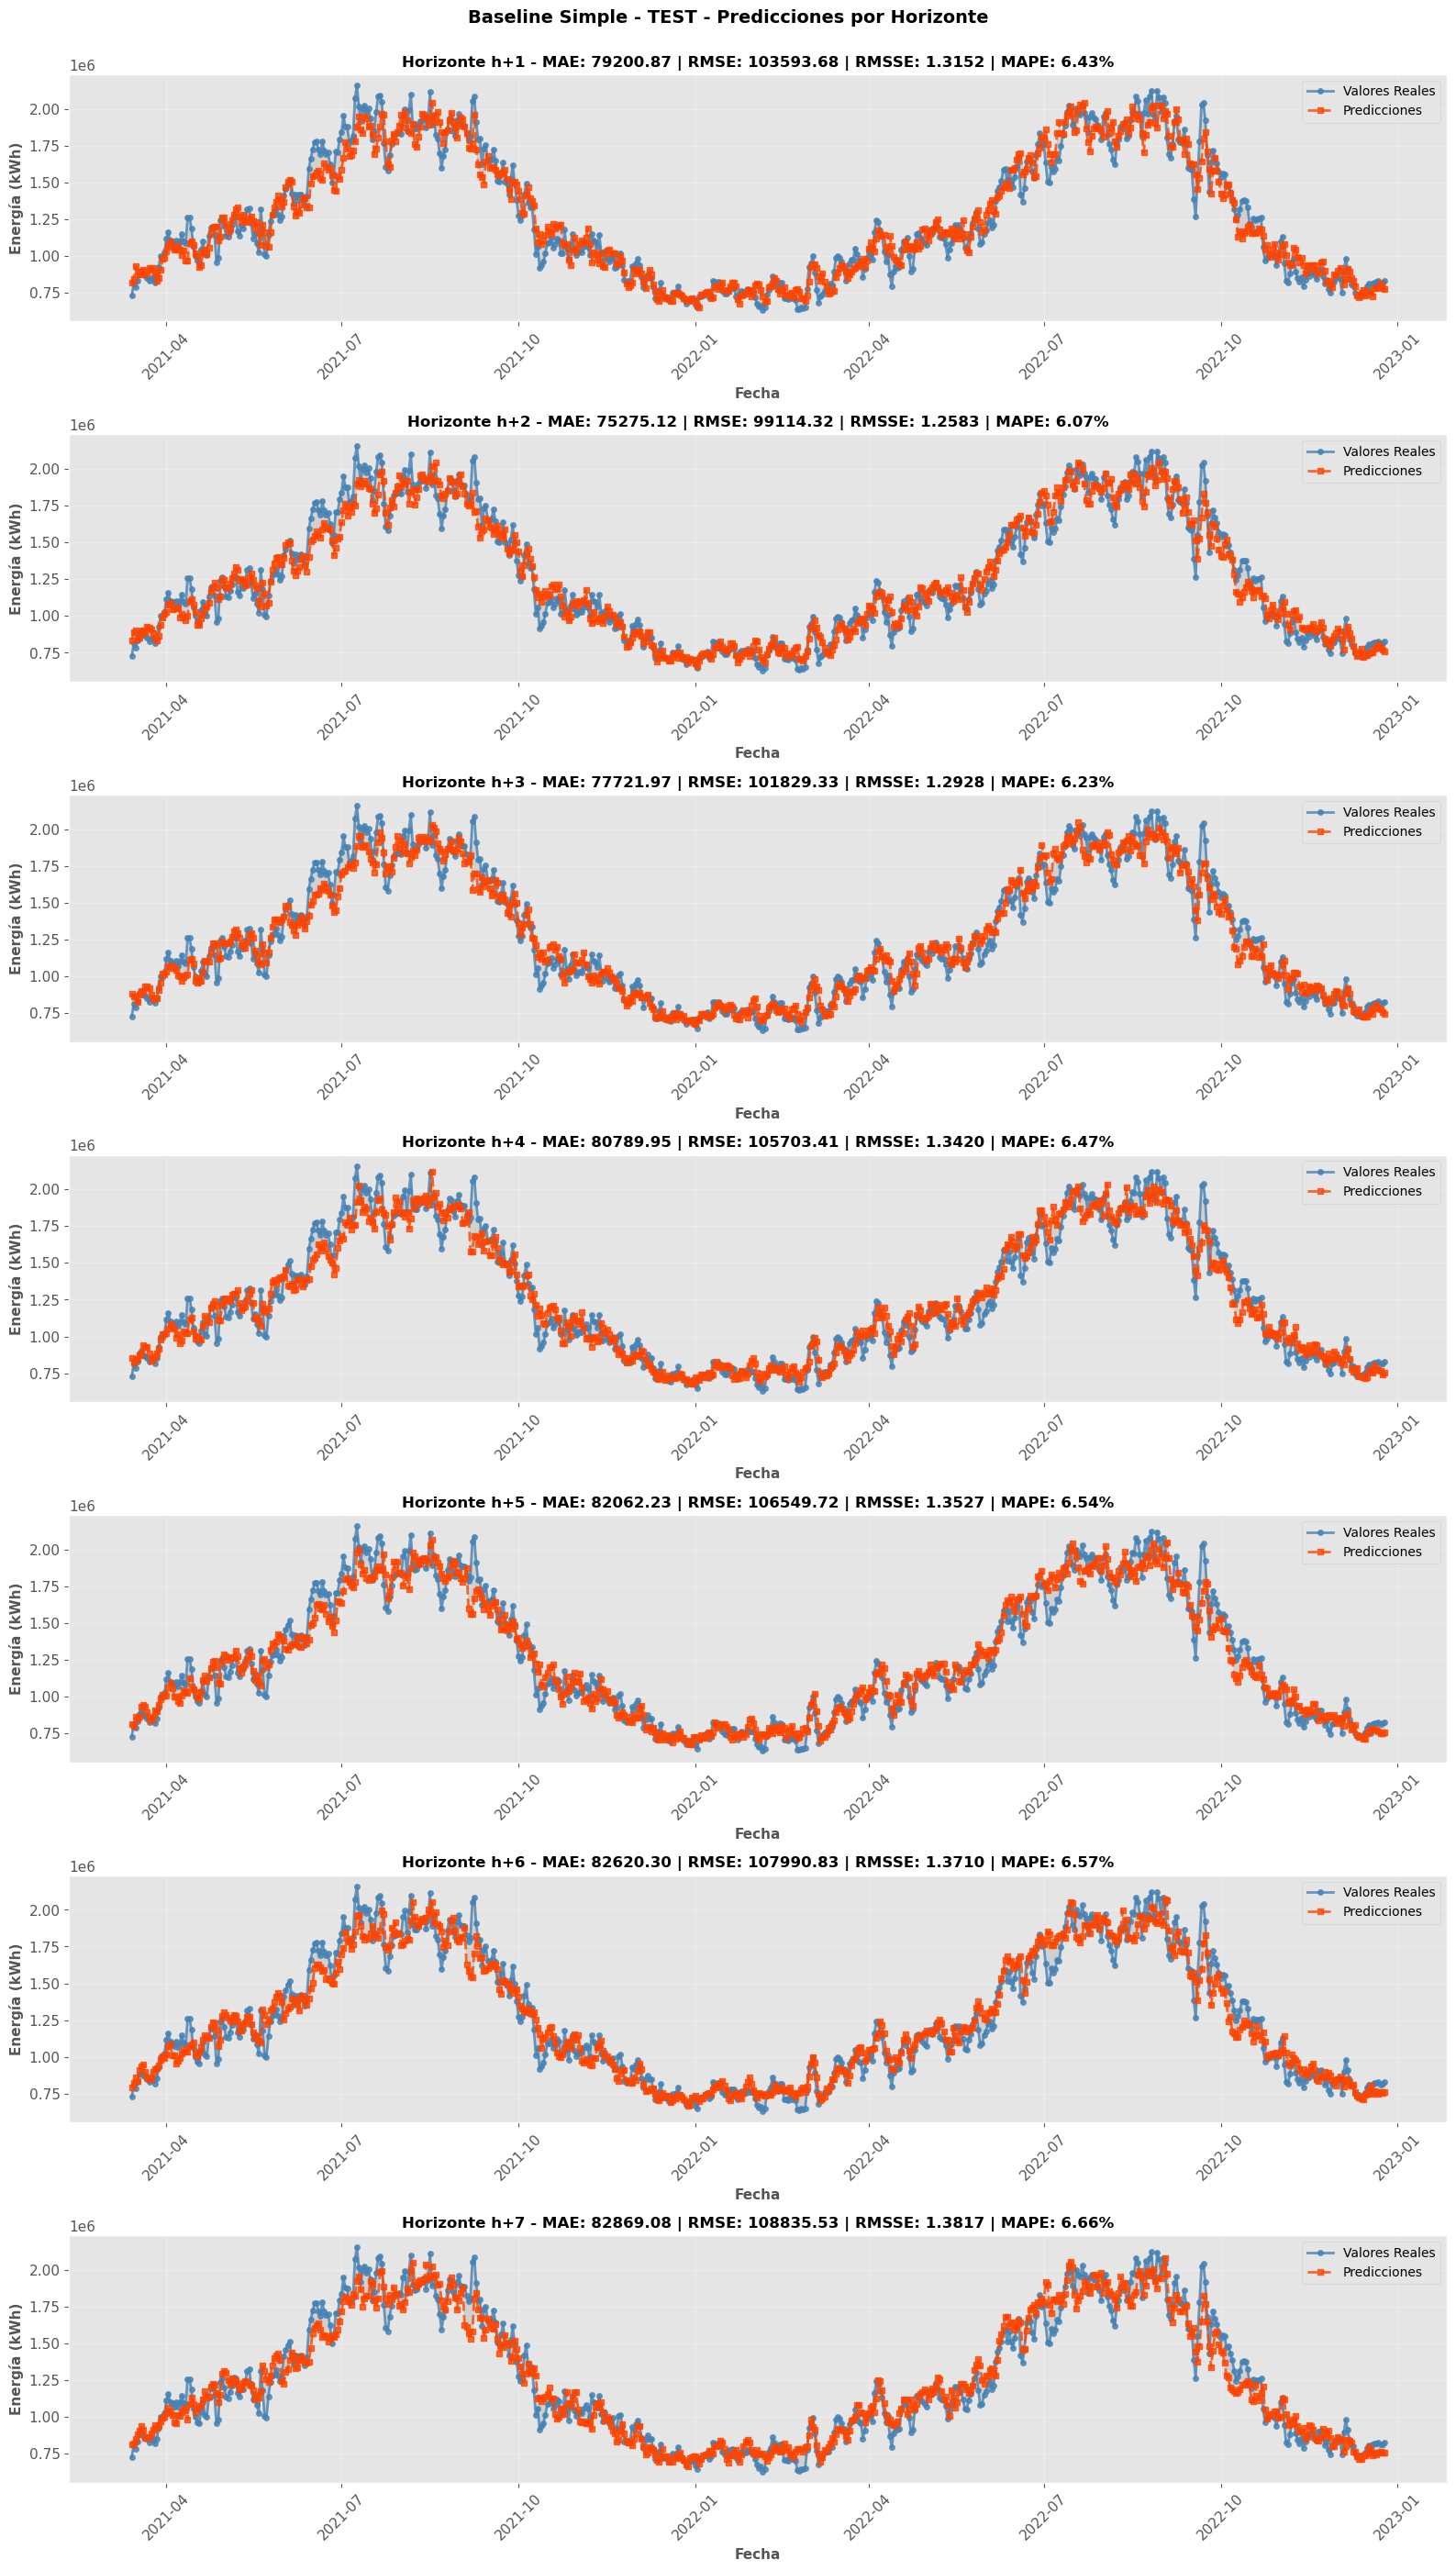

In [12]:
# Función para evaluar el baseline simple en un conjunto de datos con rolling window
def evaluar_baseline_simple(datos, horizonte, target_col, media2Dias=True,verbose=True, nombre_conjunto="datos"):
    # Diccionarios para almacenar predicciones de cada horizonte
    predicciones_por_horizonte = {h: [] for h in range(1, horizonte + 1)}
    valores_reales = []
    fechas = []
    
    # Necesitamos al menos 365 días para poder usar el año anterior
    # y poder predecir al menos horizonte días adelante
    min_inicio = 365
    
    if verbose:
        print(f"\nEvaluando baseline con rolling window en {nombre_conjunto}...")
        print(f"  Horizonte: {horizonte} días")
        print(f"  Rango de evaluación: desde índice {min_inicio} hasta {len(datos) - horizonte}")
    
    # Recorremos los datos dejando espacio para predecir 'horizonte' días adelante
    for i in range(min_inicio, len(datos) - horizonte + 1):
        # Datos disponibles hasta este punto (sin mirar hacia adelante)
        datos_hasta_aqui = datos.iloc[:i]
        
        # Para cada horizonte h
        for h in range(1, horizonte + 1):
            # Índice del día que queremos predecir
            idx_pred = i + h - 1
            
            # Valor real del día a predecir
            if h == 1:
                # Solo guardamos valores reales una vez (para h=1)
                valor_real = datos[target_col].iloc[idx_pred]
                valores_reales.append(valor_real)
                fechas.append(datos.index[idx_pred])
            
            # Calcular predicción para este horizonte
            # Usamos el valor de h-1 días antes (o el último disponible si h=1)
            if h == 1:
                # Para h=1, usamos el último valor disponible (i-1)
                valor_dia_anterior = datos_hasta_aqui[target_col].iloc[-1]
            else:
                # Para h>1, usamos el valor de idx_pred - 1
                # que está en datos_hasta_aqui si idx_pred - 1 < i
                idx_anterior = idx_pred - 1
                if idx_anterior < i:
                    valor_dia_anterior = datos_hasta_aqui[target_col].iloc[idx_anterior]
                else:
                    # Si no está disponible, usamos el último de datos_hasta_aqui
                    valor_dia_anterior = datos_hasta_aqui[target_col].iloc[-1]
            
            # Mismo día del año anterior respecto al día que queremos predecir
            idx_año_anterior = idx_pred - 365
            if idx_año_anterior >= 0 and idx_año_anterior < i:
                valor_año_anterior = datos_hasta_aqui[target_col].iloc[idx_año_anterior]
            else:
                # Si no tenemos el valor exacto del año anterior, usamos el más cercano disponible
                # dentro de datos_hasta_aqui
                idx_año_anterior_cercano = max(0, min(idx_año_anterior, i - 1))
                valor_año_anterior = datos_hasta_aqui[target_col].iloc[idx_año_anterior_cercano]
            
            if media2Dias:
                # Predicción como media simple
                pred = (valor_dia_anterior + valor_año_anterior) / 2
                predicciones_por_horizonte[h].append(pred)
            else:
                pred = (valor_año_anterior)
                predicciones_por_horizonte[h].append(pred)
    # Convertir a arrays numpy
    y_true = np.array(valores_reales)
    resultados = {'y_true': y_true, 'fechas': fechas}
    
    for h in range(1, horizonte + 1):
        resultados[f'y_h{h}'] = np.array(predicciones_por_horizonte[h])
    
    if verbose:
        print(f"  Total de predicciones por horizonte: {len(valores_reales)}")
        print(f"  Fechas: desde {fechas[0]} hasta {fechas[-1]}")
    
    return resultados

# 1. Evaluar en TRAIN con rolling window
resultados_train = evaluar_baseline_simple(
    datos=train_data[730:], # Usamos desde el año 3 en adelante como en backtesting
    horizonte=HORIZONTE,
    target_col=TARGET,
    media2Dias=True,
    nombre_conjunto="TRAIN"
)

# Calcular métricas para cada horizonte en TRAIN
metricas_baseline_train_por_horizonte = {}
for h in range(1, HORIZONTE + 1):
    metricas = calcular_metricas(
        resultados_train['y_true'], 
        resultados_train[f'y_h{h}'], 
        f"Baseline - TRAIN (h={h})",
        verbose=False
    )
    metricas_baseline_train_por_horizonte[f'h{h}'] = metricas

# 2. Evaluar en TEST con rolling window
# Concatenamos el último año de train para poder predecir usando año anterior
resultados_test = evaluar_baseline_simple(
    datos=pd.concat([train_data[-365:], test_data]),
    horizonte=HORIZONTE,
    target_col=TARGET,
    media2Dias=True,
    nombre_conjunto="TEST"
)

# Calcular métricas para cada horizonte en TEST
metricas_baseline_test_por_horizonte = {}
for h in range(1, HORIZONTE + 1):
    metricas = calcular_metricas(
        resultados_test['y_true'], 
        resultados_test[f'y_h{h}'], 
        f"Baseline - TEST (h={h})",
        verbose=False
    )
    metricas_baseline_test_por_horizonte[f'h{h}'] = metricas

# Crear diccionario compatible con visualizar_errores_horizonte para TEST
def crear_dict_visualizacion(resultados_eval, metricas_por_h, horizonte):
    """
    Crea un diccionario compatible con la función visualizar_errores_horizonte
    """
    # DataFrame de métricas por horizonte
    metricas_list = []
    for h in range(1, horizonte + 1):
        m = metricas_por_h[f'h{h}']
        metricas_list.append({
            'Horizonte': f'h+{h}',
            'MAE': m['MAE'],
            'RMSE': m['RMSE'],
            'RMSSE': m['RMSSE'],
            'MAPE': m['MAPE']
        })
    df_metricas = pd.DataFrame(metricas_list)
    
    # DataFrame de predicciones detalladas
    predicciones_list = []
    y_true = resultados_eval['y_true']
    fechas = resultados_eval['fechas']
    
    for i in range(len(y_true)):
        for h in range(1, horizonte + 1):
            y_pred_h = resultados_eval[f'y_h{h}'][i]
            predicciones_list.append({
                'ventana': i,
                'horizonte_dia': h,
                'fecha_pred': fechas[i],
                'valor_real': float(y_true[i]),
                'valor_pred': float(y_pred_h),
                'error_absoluto': float(np.abs(y_true[i] - y_pred_h)),
                'error_cuadrado': float((y_true[i] - y_pred_h) ** 2),
                'error_porcentual': float(np.abs((y_true[i] - y_pred_h) / y_true[i]) * 100) if y_true[i] != 0 else 0
            })
    
    df_predicciones = pd.DataFrame(predicciones_list)
    
    # Métricas globales (promedio de todos los horizontes)
    metricas_globales = {
        'MAE': df_metricas['MAE'].mean(),
        'RMSE': df_metricas['RMSE'].mean(),
        'RMSSE': df_metricas['RMSSE'].mean(),
        'MAPE': df_metricas['MAPE'].mean()
    }
    
    return {
        'metricas_por_horizonte': df_metricas,
        'metricas_globales': metricas_globales,
        'predicciones': df_predicciones
    }

# Crear diccionarios para visualización
dict_visualizacion_train = crear_dict_visualizacion(resultados_train, metricas_baseline_train_por_horizonte, HORIZONTE)
dict_visualizacion_test = crear_dict_visualizacion(resultados_test, metricas_baseline_test_por_horizonte, HORIZONTE)

# Mostrar métricas globales
print("\nTRAIN:")
for metrica, valor in dict_visualizacion_train['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

print("\nTEST:")
for metrica, valor in dict_visualizacion_test['metricas_globales'].items():
    if metrica == 'MAPE':
        print(f"  {metrica}: {valor:.2f}%")
    else:
        print(f"  {metrica}: {valor:.4f}")

# Guardar resultados para comparación posterior con las medias de todos los horizontes
metricas_baseline_train_media = {
    'Modelo': 'Baseline Simple - TRAIN (media horizontes)',
    **dict_visualizacion_train['metricas_globales']
}

metricas_baseline_test_media = {
    'Modelo': 'Baseline Simple - TEST (media horizontes)',
    **dict_visualizacion_test['metricas_globales']
}

resultados_modelos_cv = [metricas_baseline_train_media]
resultados_modelos_test = [metricas_baseline_test_media]

# Visualizar errores en TEST
visualizar_errores_horizonte(dict_visualizacion_test, titulo="Baseline Simple - TEST")

Podemos ver que el modelo base line realiza un total de 1528 predicciones en train y 652 en test. Los resultados del modelo baseline muestran un desempeño consistente entre los conjuntos de entrenamiento y test. En train, se obtiene un MAE de 106,552.89 kWh y un RMSE de 138,008.59 kWh, con un MAPE del 7.78%. En test, las métricas mejoran ligeramente con un MAE de 80,077.07 kWh, RMSE de 104,802.40 kWh y MAPE del 6.42%. El RMSSE se mantiene estable en torno a 1.33-1.34 en ambos conjuntos, indicando que el modelo no presenta sobreajuste y generaliza adecuadamente.

Si analizamos el error por horizonte temporal vemos que en test se aprecia como el error fluctua siendo mayor a principio y final del horizonte y mejor en los dáis intermedios. En el horizonte 2 y 3 es donde se consiguen los mejores resutlados.

## Modelos Complejos con Grid Search <a class="anchor" id="modelos"></a>

En esta sección entrenamos tres modelos más  complejos mediante búsqueda de hiperparámetros, los mismos 3 modelos que usamos en el notebook anterior:

- **Random Forest**: Ensemble de árboles de decisión. Este método además nos permite extraer las caractéristicas más influyentes en la predicción del modelo por lo que puede ser útil para determinar los lags y variables más importantes.
- **XGBoost**: Gradient boosting optimizado, tambien basado en árboles y como el anterior nos permite extraer características más influyentes en la predicción, posibilitando el análisis de importancia de lags y variables.
- **SVR**: Support Vector Regression.

Vamos a elegir una estrategia de predicción recursiva para el forecasting, ya que la seria ha demostrado cierta estacionalidad y este modelo es más óptimoo para capturarla, además es más rápido en su ejecución y debido a las limitaciones computacionales se adecua mejor a nuestro entorno de ejecución.


### Random Forest con Grid Search <a class="anchor" id="random"></a>

Se han seleccioando rangos pequeños para los hiperparámetros de random forest, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa siginificativamente la dimensionalidad del espacio de características (6 lags x 3 n_estimators x 3 max_depth = 54).

`n_estimators` [100, 200, 400]: Número de estimadores, un valor pequeño mantiene al modelo sencillo y eficiente, mientras que un valor más elevado permite capturar relaciones más complejas de los datos.

`max_depth` [3, 5, 8]: La profundidad pequeña reduce el riesgo de memorización de patrones inecesarios de los datos de entrenamiento, permitiendo una mayor generalización

In [ ]:
# Crear forecaster recursivo
rf_forecaster = ForecasterRecursiveMultiSeries(
    regressor=RandomForestRegressor(random_state=SEED, n_jobs=-1),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
)
# Definir grid de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3,5, 8],
}
# Ejecutar grid search con cv específico para validación interna
results_rf = grid_search_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,
    exog=exog_train,
    param_grid=param_grid_rf,
    lags_grid=lags_grid,
    cv=cv,  
    metric='root_mean_squared_scaled_error',
    return_best=True,
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

lags grid:   0%|          | 0/5 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

Podemos ver que el grid de lag con mejor resultado es el [1 al 30] que captura patrones semanales y mensual junto con los parámetros 'max_depth': 8 y 'n_estimators': 200 que mantienen los árboles simples con poca profundidadd, mientras que el número de estimadores permite encontrar 

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre el conjunto de train
metricas_bt_rf, predicciones_bt_rf = backtesting_forecaster_multiseries(
    forecaster=rf_forecaster,
    series=train_data,  
    exog=exog_train,    
    cv=cv,              
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_rf = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_rf = predicciones_bt_rf['pred']
metricas_rf = calcular_metricas(
    y_true_bt_rf,
    y_pred_bt_rf,
    nombre_modelo="Random Forest - Backtesting"
)
resultados_modelos_cv.append(metricas_rf)

El modelo Random Forest en backtesting obtiene un MAE de 115074.396 kWh, superior 
al 106552.89 kWh del baseline en train. El RMSE también es mayor 
(156718.378 kWh vs 138008.59 kWh), al igual que el RMSSE (1.60 vs 1.34) y el 
MAPE (8.49% vs 7.78%). Estos resultados indican que, en esta configuración, 
Random Forest no supera el rendimiento del modelo baseline simple.

In [ ]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =rf_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

En cuanto al análisis de características más importantes podemos ver que la mayor parte de la predicción se genera en base al 'lag_1' que sería el último día que se conoce y 'dia_semana', la variable exógena que retiene la estacionaldiad semanal, junto con el 'lag_7' que concuerda con la estacionalidad semanal.

Ahora analizaremos si hay overfiting del modelo y las métricas obtenidas en el conjunto de test.

In [ ]:
resultados_rf = calcular_errores_por_horizonte(
    modelo=rf_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(rf_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_rf, titulo="Random Forest - Errores por Horizonte")

In [ ]:
resultados_modelos_test.append({'Modelo': 'Random Forest - TEST'} | resultados_rf['metricas_globales'])
resultados_rf['metricas_globales']

El modelo Random Forest en test obtiene un MAE de 96992.6 kWh, RMSE de 127180.42 kWh, RMSSE de 1.61 y MAPE de 7.93%. 

El modelo muestra una mejora significativa en test respecto a su desempeño en backtesting (train). El MAE disminuye de 115074.396 kWh a 96992.60 kWh, el RMSE de 156718.37 kWh a 127180.42 kWh, el RMSSE de 1.62 a 1.61, y el MAPE de 8.49% a 7.93%. Esta mejora en test sugiere que el modelo generaliza mejor de lo esperado, posiblemente debido a características más predecibles en el periodo de test.

Comparando con el baseline en test (MAE: 80,077.07 kWh, RMSE: 104,802.40 kWh, RMSSE: 1.33, MAPE: 6.42%), Random Forest presenta un rendimiento inferior en todas las métricas: MAE, RMSE, RMSSE y MAPE. A pesar de su mayor complejidad y uso de múltiples lags, Random Forest no logra superar el modelo baseline simple, lo que indica que la configuración actual de hiperparámetros no es óptima o que el enfoque basado en media del día anterior y el mismo día del año anterior es suficientemente robusto para esta serie temporal.


Si analizamos los resultados por horizonte, vemos como Random Forest funciona mejor en horizontes pequeños empezando con un MAPE de 4,31% en el horizonte h+1 y terminando con un error de 9,73% en el horizonte h+7. A diferencia del modelo baseline que mantenia un MAPE entre 6 y 6,6. El modelo de Random Forest funciona mejor para el horizonte h+1 mientras el resultado se degrada siginificativamente con el aumento del horizonte.

Por otro lado se puede observar como las predicciónes se adaptan bien al movimiento general de la gráfica difiriendo principalmente en entornos locales.

### XGBoost con Grid Search <a class="anchor" id="xgboost"></a>

Se han seleccionado rangos pequeños para los hiperparámetros de XGBoost, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa significativamente la dimensionalidad del espacio de características (6 lags × 3 min_child_weight × 3 learning_rate x 3 max_depth = 162 combinaciones).

**learning_rate** [0.3, 0.2, 0.1]: Tasa de aprendizaje que controla la contribución de cada árbol al modelo final. Valores más bajos (0.1) hacen que el modelo aprenda de forma más conservadora, requiriendo más iteraciones pero reduciendo el riesgo de sobreajuste. Valores más altos (0.3) aceleran el aprendizaje pero pueden provocar convergencia prematura a mínimos locales. Este rango explora desde aprendizaje moderado-rápido hasta conservador.


**min_child_weight** [1, 3, 5]: Suma mínima de pesos requerida en un nodo hijo para permitir una división. Valores más altos (5) previniendo la creación de nodos con pocas observaciones y reduciendo el sobreajuste. Valores bajos (1) permiten mayor flexibilidad en las divisiones.

**max_depth** [3, 6, 9]: Profundidad máxima de cada árbol. XGBoost. El rango [3, 6, 9] permite explorar árboles muy simples y árboles moderadamente complejos. Valores bajos reducen el riesgo de memorización de patrones en entrenamiento que no existan en la realidad.

In [ ]:
# Crear forecaster recursivo
xgb_forecaster = ForecasterRecursiveMultiSeries(
    regressor=XGBRegressor(random_state=SEED, n_jobs=-1, verbosity=0),
    lags=LAGS,
    transformer_series=None,
    transformer_exog=None,
)

# Definir grid de hiperparámetros
param_grid_xgb = {
    'learning_rate': [0.3, 0.2,0.1],
    'max_depth': [3,6,9],
    'min_child_weight': [1,3,5],
}


# Ejecutar grid search con cv específico para validación interna
results_xgb = grid_search_forecaster_multiseries(
    forecaster=xgb_forecaster,
    param_grid=param_grid_xgb,
    lags_grid=lags_grid,
    series=train_data,  
    exog=exog_train,    
    cv=cv,              
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)


Podemos ver que el grid de lag con mejor resultado es el [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 365] que captura patrones semanales y anuales, junto con los parámetros 'learning_rate': 0.1, 'max_depth': 3 y 'min_child_weight': 5. A diferencia de random forest que no utiliza patrones anuales. Y que tiene mayor profundiad.

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_xgb, predicciones_bt_xgb = backtesting_forecaster_multiseries(
    forecaster=xgb_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_xgb = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_xgb = predicciones_bt_xgb['pred']
metricas_xgb = calcular_metricas(
    y_true_bt_xgb,
    y_pred_bt_xgb,
    nombre_modelo="XGBoost - Backtesting"
)
resultados_modelos_cv.append(metricas_xgb)

El modelo XGBoost en backtesting obtiene un MAE de 111458.72 kWh, superior al 106552.89 del modelo de linea base pero inferior al 115074.396 del modelo Random Forest. En cuanto al RMSE obtiene un valor de 151216.15 ligeramente inferior al valor de Random Forest y bastante superior al modelo de linea base. Sobre RMSSE ocurre igual que con RMSE y en MAPE obtiene mejor métrica que Random Forest y peor que el modelo de linea base.

In [ ]:
# Análisis de importancia de lags para Random Forest
import matplotlib.pyplot as plt
import pandas as pd

importance_df =xgb_forecaster.get_feature_importances().sort_values(ascending=False, by='importance')
importance_df['importance'] = importance_df['importance'] * 100

print(importance_df.head(20).to_string(
    formatters={'importance': '{:.2f}%'.format}
))

Encuanto a la importancia de las características el 'lag_1' vuelve a destacar como el más importante para la predicción aunque con un valor inferior al que da Random Forest. Este modelo tambien da importancia al lag_7 y lag_6 capturando mejor la estacionalidad semanal y a los lags 363 y 360 que capturan estacionalidad anual. 'dia_semana' pierde relevancia en comparación con el Random Forest.

Ahora analizaremos los resultados del mejor modelo en datos de test. Y por horizonte temporal.

In [ ]:
resultados_xgb = calcular_errores_por_horizonte(
    modelo=xgb_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(xgb_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_xgb, titulo="XGBoost - Errores por Horizonte")

In [ ]:
resultados_modelos_test.append({'Modelo': 'XGBoost - TEST'} | resultados_xgb['metricas_globales'])

resultados_xgb['metricas_globales']

Analizando las métricas de resultados en TEST podemos ver que no hay overfitting y que los datos de TEST son ligeramente mejores que los de train en todas las métricas. El modelo consigue en train un MAE de 111458.72 vs 90448.39 en test. En cuanto al RMSE consigue un valor de 151216.15 en train vs un 119018.90 en test. Para RMSSE se consigue un valor de1.5495 en train frente a un 1.5121 en test y por último el MAPE es de 8.20% en train vs 7.40% en test. Los valores son suficientemente cercanos para considerar que el modelo generaliza bien. 

Encuanto a la comparativa con el modelo baseline. No conseguimos mejorar ninguna métrica. Lo cual indica que el modelo con estos parámetros no es suficientemente ajustado o que el modelo baseline es suficientemente robusto.

### SVR con Grid Search <a class="anchor" id="svr"></a>

Se han seleccionado rangos pequeños para los hiperparámetros de XGBoost, con el objetivo de prevenir sobreajuste y agilizar la ejecución, considerando que el modelo ya va a probar múltiples lags de la variable objetivo como predictor, lo que incrementa significativamente la dimensionalidad del espacio de características (6 lags × 3 C × 3 epsilon x 3 gamma = 162 combinaciones).

**C** [0.1, 1, 10]: Parámetro de regularización que controla el trade-off entre maximizar el margen y minimizar el error de entrenamiento. Valores bajos (0.1) permiten mayor violación del margen, favoreciendo generalización a costa de mayor error en train. Valores altos (10) penalizan fuertemente los errores, ajustándose más a los datos de entrenamiento con riesgo de sobreajuste.

**epsilon** [0.01, 0.1, 0.5]: Valores pequeños (0.01) exigen predicciones muy precisas, creando un modelo más ajustado. Valores grandes (0.5) permiten mayor tolerancia a errores pequeños, resultando en modelos más simples y robustos.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Crear forecaster con datos normalizados (importante para SVR) - Recursivo
svr_forecaster = ForecasterRecursiveMultiSeries(
    regressor=SVR(),
    lags=LAGS,
    transformer_series=StandardScaler(),
)

# Definir grid de hiperparámetros
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1]
}

# Ejecutar grid search con cv específico para validación interna
# IMPORTANTE: Usar datos ESCALADOS para SVR
results_svr = grid_search_forecaster_multiseries(
    forecaster=svr_forecaster,
    param_grid=param_grid_svr,
    lags_grid=lags_grid,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

Podemos ver que el grid de lag con mejor resultado es el [1, 2, 3, 4, 5, 6, 7, 359, 360, 361, 362, 363, 365] que captura patrones semanales y anuales igual que XGBoost, junto con los parámetros 'C': 10, 'epsilon': 0.1, 'gamma': 0.01 y 'kernel': 'rbf'.

Ahora vamos a realizar el backtesting con las particiones definidas en el apartado anterior, sobre el mejor modelo entrenado

In [ ]:
# Realizar backtesting usando TimeSeriesFold sobre TODO el conjunto de test
metricas_bt_svr, predicciones_bt_svr = backtesting_forecaster_multiseries(
    forecaster=svr_forecaster,
    series=train_data,  # Serie completa
    exog=exog_train,    # Variables exógenas
    cv=cv,              # Usar TimeSeriesFold
    levels=TARGET,
    metric=['mean_absolute_error', 'root_mean_squared_scaled_error','mean_absolute_percentage_error'],
    n_jobs='auto',
    verbose=False,
    show_progress=True
)
y_true_bt_svr = train_data[TARGET].iloc[initial_train_size:]  # Ajustar índice para el backtesting
y_pred_bt_svr = predicciones_bt_svr['pred']
metricas_svr = calcular_metricas(
    y_true_bt_svr,
    y_pred_bt_svr,
    nombre_modelo="SVR - Backtesting"
)
resultados_modelos_cv.append(metricas_svr)

El modelo SVR en backtesting obtiene un MAE de 106176.32 kWh, ligeramente inferior al 106552.89 del modelo de linea base e inferior al resultado de XGBoost y Random Forest. En cuanto al RMSE obtiene un valor de 141682.63  inferior al valor de Random Forest y XGBoost, pero superior al modelo de linea base. Sobre RMSSE ocurre igual que con RMSE y en MAPE tambien obtiene métricas mejores que Random Forest y XGBoost, pero ligeramente peores que el modelo de linea base.

In [ ]:
resultados_svr = calcular_errores_por_horizonte(
    modelo=svr_forecaster,
    test_data=test_data,
    train_data=train_data,  # Añadir esto para tener suficientes lags
    offset_lags=max(svr_forecaster.lags),
    exog_test=exog_test,
    horizonte=HORIZONTE,
    target_col=TARGET,
    verbose=True
)
visualizar_errores_horizonte(resultados_svr, titulo="SVR - Errores por Horizonte")

In [ ]:
resultados_modelos_test.append({'Modelo': 'SVR - TEST'} | resultados_svr['metricas_globales'])

resultados_svr['metricas_globales']

Analizando las métricas de resultados en TEST podemos ver que no hay overfitting y que los datos de TEST son ligeramente mejores que los de train en todas las métricas. El modelo consigue en train un MAE de 106176.32 vs 88108.14 en test. En cuanto al RMSE consigue un valor de 141682.63 en train vs un 115646.27 en test. Para RMSSE se consigue un valor de 1.4518 en train frente a un 1.4693 en test y por último el MAPE es de 8.04% en train vs 7.11% en test. Los valores son suficientemente cercanos para considerar que el modelo generaliza bien. 

Encuanto a la comparativa con el modelo baseline. No conseguimos mejorar ninguna métrica. Lo cual indica que el modelo con estos parámetros no es suficientemente ajustado o que el modelo baseline es suficientemente robusto. Pero si que conseguimos mejorar los resultados de test de Random Forest y XGBoost. Este es hasta ahora el mejor modelo de ML entrenado con estrategias multivariantes.

Comparando métricas por horizonte los errores van aumentando conforme aumenta el horizonte, empezando en un MAPE de 4.2% en h+1 y terminando en un MAPE de 8.26% en h+7. Es mejor que el modelo de linea base para el primer horizonte, pero empeora apartir de ahí más que el modelo de linea base.

## Comparación y Conclusiones <a class="anchor" id="conclu"></a>

En esta sección final comparamos todos los modelos entrenados y presentamos las conclusiones más relevantes del análisis.

- 1 Baseline (Solución naive)
- 3 Modelos Recursivos (Random Forest, XGBoost, SVR)

In [ ]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_modelos_cv)
df_resultados = df_resultados.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'Baseline Simple - TRAIN (media horizontes)']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))

Como hemos ido viendo el modelo baseline simple que hemos realizado con la media del dia anterior y el valor del mismo día del año anterior funciona mejor que todos los modelos entrenados en test. Esto indica que esa función simple puede capturar bien la estacionalidad de los datos y el uso de modelos más complejos no consiguen adaptarse mejor. Aún así se puede ver como el modelo SVR es el que mejor funciona y puede competir con el resultado obtenido por el modelo de linea base. 

Por otro lado destacan  los lags 1 y 7 como los más útiles para realizar las predicciones. Subrayando la estacionalidad semanal de la serie. 




In [ ]:
# Crear DataFrame con resultados
df_resultados_test = pd.DataFrame(resultados_modelos_test)
df_resultados_test = df_resultados_test.sort_values('RMSSE')

print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados_test.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados_test.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados_test[df_resultados_test['Modelo'] == 'Baseline Simple - TEST (media horizontes)']['RMSSE'].values[0]
mejor_rmsse = df_resultados_test.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados_test.style.background_gradient(subset=['MAE', 'RMSSE','RMSE','MAPE'], cmap='RdYlGn_r')
                          .format({'MAE': '{:.3f}', 'RMSE': '{:.4f}', 'RMSSE': '{:.4f}', 'MAPE': '{:.2f}%'}))

En datos de test podemos ver la misma tendencía que con train, ningún modelo ha tenido overfitting, pero tampoco se ha conseguido mejorar el resultado del modelo de linea base. Si que podemos destacar que los si desglosamos el error por horizonte. Todos los modelos consiguen una mejor predicción en h+1 y se acercan bastante al modelo de liena base en h+2. Mientras que para el resto de horizontes el resultado de los modelos es peor que el modelo de linea base.

## Uso de IA Generativa <a class="anchor" id="genia"></a>


**Prompt**: En base a un dataframe con las siguientes columnas Modelo, MAE, R2 y RMSSE, crea una visualización con diagrama de barras de los distintos errores, por modelo. 
Además crea una tabla con los valores ordenados por RMSSE para ver que modelo funciona mejor.

**Modificaciones:** Tras canbiar las métricas por MAE, RMSE, RMSSE y MAPE. Hemos tenido que cambiar las gráficas de resultado
```Python

print("\n📈 GRÁFICA COMPARATIVA DE MÉTRICAS:")

# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


print("\nTABLA DE RESULTADOS (ordenado por RMSSE):")
print("\n" + df_resultados.to_string(index=False))

# Identificar el mejor modelo
mejor_modelo = df_resultados.iloc[0]['Modelo']


# Mostrar mejoras respecto al baseline
baseline_rmsse = df_resultados[df_resultados['Modelo'] == 'LightGBM Baseline']['RMSSE'].values[0]
mejor_rmsse = df_resultados.iloc[0]['RMSSE']
mejora = ((baseline_rmsse - mejor_rmsse) / baseline_rmsse) * 100

print(f"\nMejora respecto al baseline: {mejora:.2f}% en RMSSE")

display(df_resultados.style.background_gradient(subset=['MAE', 'RMSSE'], cmap='RdYlGn_r')
                          .background_gradient(subset=['R²'], cmap='RdYlGn')
                          .format({'MAE': '{:.3f}', 'R²': '{:.4f}', 'RMSSE': '{:.4f}'}))
```
**Prompt**: Crea una gráfica para mostrar los resultados de predicción del siguiente modelo:
prediccion_inicial = baseline_forecaster.predict(steps=HORIZONTE, levels=TARGET)
con HORIZONTE=7 y TARGET = Energía total (kWh). Ten en cuenta que quiero mostrar los 30 días anteriores a la predicción y el resultado predicho y el resultado original. Calcula tambien el MAE, RMSSE y R2.

**Consideraciones**: El código se tuvo  que adaptar, principalmente nombres de variales y accesos a diccionraios
```Python
# Gráfica comparativa de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colores para cada modelo
colors = ['steelblue', 'darkorange', 'green', 'crimson']

# MAE
axes[0].bar(df_resultados['Modelo'], df_resultados['MAE'], color=colors)
axes[0].set_ylabel('MAE (kWh)', fontweight='bold')
axes[0].set_title('Mean Absolute Error', fontweight='bold', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# R²
axes[1].bar(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_ylabel('R² Score', fontweight='bold')
axes[1].set_title('Coeficiente de Determinación', fontweight='bold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='R²=0.8')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# RMSSE
axes[2].bar(df_resultados['Modelo'], df_resultados['RMSSE'], color=colors)
axes[2].set_ylabel('RMSSE', fontweight='bold')
axes[2].set_title('Root Mean Squared Scaled Error', fontweight='bold', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación de Métricas entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Visualizar la predicción
fig, ax = plt.subplots(figsize=(16, 6))

# Mostrar últimos 30 días de entrenamiento
ultimos_dias_train = train[TARGET].iloc[-30:]
ax.plot(ultimos_dias_train.index, ultimos_dias_train, 
        'o-', color='steelblue', label='Entrenamiento (últimos 30 días)', 
        linewidth=2, markersize=5)

# Mostrar primeros 7 días de test (valores reales)
primeros_dias_test = test[TARGET].iloc[:HORIZONTE]
ax.plot(primeros_dias_test.index, primeros_dias_test, 
        'o-', color='orangered', label='Valores reales (test)', 
        linewidth=2, markersize=6)

# Mostrar predicción del baseline
ax.plot(prediccion_inicial.index, prediccion_inicial.value, 
        's--', color='green', label='Predicción LightGBM Baseline', 
        linewidth=2, markersize=5, alpha=0.8)

# Área sombreada para el error
ax.fill_between(primeros_dias_test.index, 
                primeros_dias_test, 
                prediccion_inicial.value,
                alpha=0.2, color='gray', label='Error de predicción')

ax.set_xlabel('Fecha', fontsize=12, fontweight='bold')
ax.set_ylabel('Energía total (kWh)', fontsize=12, fontweight='bold')
ax.set_title(f'Predicción del Modelo Baseline - Horizonte de {HORIZONTE} días', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular métricas básicas de esta predicción inicial
mae_inicial = mean_absolute_error(primeros_dias_test, prediccion_inicial['pred'])

scale = np.mean(np.diff(primeros_dias_test)**2)
mse = mean_squared_error(primeros_dias_test, prediccion_inicial['pred'])
rmsse_inicial = np.sqrt(mse / scale) if scale > 0 else np.sqrt(mse)
r2_inicial = r2_score(primeros_dias_test, prediccion_inicial['pred'])

print(f"\nMétricas de la predicción inicial (primeros {HORIZONTE} días):")
print(f"  • MAE  = {mae_inicial:.3f} kW")
print(f"  • RMSSE = {rmsse_inicial:.3f} kW")
print(f"  • R²   = {r2_inicial:.4f}")

```


## Entorno de Ejecución <a class="anchor" id="entorno"></a>

In [ ]:
import sklearn
sklearn.show_versions()

In [ ]:
from sinfo import sinfo

sinfo()

Resultado Recursivo previo con Emisiones y sin usar el lag de hace un año

<style type="text/css">
#T_22f64_row0_col1, #T_22f64_row0_col2, #T_22f64_row0_col3, #T_22f64_row1_col1, #T_22f64_row1_col2, #T_22f64_row1_col3, #T_22f64_row2_col1, #T_22f64_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_22f64_row2_col3 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_22f64_row3_col1, #T_22f64_row3_col2, #T_22f64_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_22f64">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_22f64_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_22f64_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_22f64_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_22f64_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_22f64_level0_row0" class="row_heading level0 row0" >3</th>
      <td id="T_22f64_row0_col0" class="data row0 col0" >Support Vector Regression</td>
      <td id="T_22f64_row0_col1" class="data row0 col1" >117703.017</td>
      <td id="T_22f64_row0_col2" class="data row0 col2" >0.8942</td>
      <td id="T_22f64_row0_col3" class="data row0 col3" >1.5751</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row1" class="row_heading level0 row1" >2</th>
      <td id="T_22f64_row1_col0" class="data row1 col0" >XGBoost</td>
      <td id="T_22f64_row1_col1" class="data row1 col1" >113668.079</td>
      <td id="T_22f64_row1_col2" class="data row1 col2" >0.8914</td>
      <td id="T_22f64_row1_col3" class="data row1 col3" >1.5954</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row2" class="row_heading level0 row2" >1</th>
      <td id="T_22f64_row2_col0" class="data row2 col0" >Random Forest</td>
      <td id="T_22f64_row2_col1" class="data row2 col1" >117840.469</td>
      <td id="T_22f64_row2_col2" class="data row2 col2" >0.8869</td>
      <td id="T_22f64_row2_col3" class="data row2 col3" >1.6279</td>
    </tr>
    <tr>
      <th id="T_22f64_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_22f64_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_22f64_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_22f64_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_22f64_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultado recursivo previo sin emisiones y con el lags [1,2,3,4,5,6,7,365]

<style type="text/css">
#T_2c916_row0_col1, #T_2c916_row0_col2, #T_2c916_row0_col3, #T_2c916_row1_col2, #T_2c916_row1_col3, #T_2c916_row2_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_2c916_row1_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_2c916_row2_col1, #T_2c916_row2_col3 {
  background-color: #026c39;
  color: #f1f1f1;
}
#T_2c916_row3_col1, #T_2c916_row3_col2, #T_2c916_row3_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_2c916">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_2c916_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_2c916_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_2c916_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_2c916_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_2c916_level0_row0" class="row_heading level0 row0" >1</th>
      <td id="T_2c916_row0_col0" class="data row0 col0" >Random Forest</td>
      <td id="T_2c916_row0_col1" class="data row0 col1" >112091.915</td>
      <td id="T_2c916_row0_col2" class="data row0 col2" >0.8969</td>
      <td id="T_2c916_row0_col3" class="data row0 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_2c916_row1_col0" class="data row1 col0" >Support Vector Regression</td>
      <td id="T_2c916_row1_col1" class="data row1 col1" >117655.759</td>
      <td id="T_2c916_row1_col2" class="data row1 col2" >0.8963</td>
      <td id="T_2c916_row1_col3" class="data row1 col3" >1.5589</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row2" class="row_heading level0 row2" >2</th>
      <td id="T_2c916_row2_col0" class="data row2 col0" >XGBoost</td>
      <td id="T_2c916_row2_col1" class="data row2 col1" >123646.833</td>
      <td id="T_2c916_row2_col2" class="data row2 col2" >0.8799</td>
      <td id="T_2c916_row2_col3" class="data row2 col3" >1.6781</td>
    </tr>
    <tr>
      <th id="T_2c916_level0_row3" class="row_heading level0 row3" >0</th>
      <td id="T_2c916_row3_col0" class="data row3 col0" >LightGBM Baseline</td>
      <td id="T_2c916_row3_col1" class="data row3 col1" >1382502.186</td>
      <td id="T_2c916_row3_col2" class="data row3 col2" >-8.5619</td>
      <td id="T_2c916_row3_col3" class="data row3 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

Resultados recursivo y directo con varios lags [1..7, 365],[1..14, 365],[1..21, 365]

<style type="text/css">
#T_407fa_row0_col1, #T_407fa_row4_col1 {
  background-color: #016a38;
  color: #f1f1f1;
}
#T_407fa_row0_col2, #T_407fa_row0_col3, #T_407fa_row1_col1, #T_407fa_row1_col2, #T_407fa_row1_col3, #T_407fa_row2_col1, #T_407fa_row2_col2, #T_407fa_row2_col3, #T_407fa_row3_col1, #T_407fa_row3_col2, #T_407fa_row3_col3, #T_407fa_row4_col2, #T_407fa_row4_col3, #T_407fa_row5_col2 {
  background-color: #006837;
  color: #f1f1f1;
}
#T_407fa_row5_col1 {
  background-color: #04703b;
  color: #f1f1f1;
}
#T_407fa_row5_col3 {
  background-color: #036e3a;
  color: #f1f1f1;
}
#T_407fa_row6_col1, #T_407fa_row6_col2, #T_407fa_row6_col3 {
  background-color: #a50026;
  color: #f1f1f1;
}
</style>
<table id="T_407fa">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_407fa_level0_col0" class="col_heading level0 col0" >Modelo</th>
      <th id="T_407fa_level0_col1" class="col_heading level0 col1" >MAE</th>
      <th id="T_407fa_level0_col2" class="col_heading level0 col2" >R²</th>
      <th id="T_407fa_level0_col3" class="col_heading level0 col3" >RMSSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_407fa_level0_row0" class="row_heading level0 row0" >6</th>
      <td id="T_407fa_row0_col0" class="data row0 col0" >Support Vector Regression (Directo)</td>
      <td id="T_407fa_row0_col1" class="data row0 col1" >116446.240</td>
      <td id="T_407fa_row0_col2" class="data row0 col2" >0.8990</td>
      <td id="T_407fa_row0_col3" class="data row0 col3" >1.5385</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row1" class="row_heading level0 row1" >3</th>
      <td id="T_407fa_row1_col0" class="data row1 col0" >XGBoost (Recursivo)</td>
      <td id="T_407fa_row1_col1" class="data row1 col1" >110924.292</td>
      <td id="T_407fa_row1_col2" class="data row1 col2" >0.8987</td>
      <td id="T_407fa_row1_col3" class="data row1 col3" >1.5409</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row2" class="row_heading level0 row2" >5</th>
      <td id="T_407fa_row2_col0" class="data row2 col0" >Support Vector Regression (Recursivo)</td>
      <td id="T_407fa_row2_col1" class="data row2 col1" >115647.635</td>
      <td id="T_407fa_row2_col2" class="data row2 col2" >0.8983</td>
      <td id="T_407fa_row2_col3" class="data row2 col3" >1.5439</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row3" class="row_heading level0 row3" >1</th>
      <td id="T_407fa_row3_col0" class="data row3 col0" >Random Forest (Recursivo)</td>
      <td id="T_407fa_row3_col1" class="data row3 col1" >112091.915</td>
      <td id="T_407fa_row3_col2" class="data row3 col2" >0.8969</td>
      <td id="T_407fa_row3_col3" class="data row3 col3" >1.5545</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row4" class="row_heading level0 row4" >2</th>
      <td id="T_407fa_row4_col0" class="data row4 col0" >Random Forest (Directo)</td>
      <td id="T_407fa_row4_col1" class="data row4 col1" >120211.642</td>
      <td id="T_407fa_row4_col2" class="data row4 col2" >0.8922</td>
      <td id="T_407fa_row4_col3" class="data row4 col3" >1.5899</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row5" class="row_heading level0 row5" >4</th>
      <td id="T_407fa_row5_col0" class="data row5 col0" >XGBoost (Directo)</td>
      <td id="T_407fa_row5_col1" class="data row5 col1" >131325.082</td>
      <td id="T_407fa_row5_col2" class="data row5 col2" >0.8703</td>
      <td id="T_407fa_row5_col3" class="data row5 col3" >1.7433</td>
    </tr>
    <tr>
      <th id="T_407fa_level0_row6" class="row_heading level0 row6" >0</th>
      <td id="T_407fa_row6_col0" class="data row6 col0" >LightGBM Baseline</td>
      <td id="T_407fa_row6_col1" class="data row6 col1" >1382502.186</td>
      <td id="T_407fa_row6_col2" class="data row6 col2" >-8.5619</td>
      <td id="T_407fa_row6_col3" class="data row6 col3" >14.9712</td>
    </tr>
  </tbody>
</table>

- DONE: Solo recursivo 
- DONE: Métricas MAE, RMSE, RMSSE, MAPE
- DONE: Grid de lags [7,30,183,365,[1,2,3,4,5,6,7,359,360,361,362,363,364,365]]
- DONE: Modelo baseline sencillo con media con día anterior y mismo día hace un año, para el siguiente día la media del día que acabas de predecir y el mismo dia del año anterior así hasta el horizonte 7.
- DONE: ver caracteristicas-Lags más importantes
- TODO: Predicciones desglosadas por días y medir error con una función custom h+1..h+7

DIA,   0,     1,          2,     3,    4,    5,    6,    7,
   ,x1.1,  x1.2,   x1.3    , x1.4 , x1.5, x1.6, x1.7, 
           x2.1,   x2.2    , x2.3 , x2.4, x2.5, x2.6, x2.7,

errorHorizonteH1 = mean (X_.1)
errorHorizonteH2 = mean (X_.2)
errorHorizonteH3 = mean (X_.3)
errorHorizonteH4 = mean (X_.4)
errorHorizonteH5 = mean (X_.5)
errorHorizonteH6 = mean (X_.6)
errorHorizonteH7 = mean (X_.7)            